# Assignment 2:  Implicit Neural Representation

Name: **Tharun Vadakke Puthanveettil**

UID:  **119069516**

Link to Google Drive : **https://drive.google.com/file/d/1edTFpslxfDxfX84gkt91TI0dgGHrZuRq/view?usp=sharing**

Please submit a PDF containing all outputs to gradescope by **October 31, 11:59pm**

----------------------------

In this assignment, you will get some hands-on experience with implicit neural representation (INR). With INR, we parameterize some signal (in our case images) with a neural network (in this assignment, we will use a basic feed-forward network). While in practice this might be useful for outpainting, super-resolution, and compression, in this assignment we will mainly focus on the basics, with some proof-of-concept outpainting at the end. Your outputs might not look great, this is okay as long as they are at least as good as the examples.

## Dataset

As always, we start with the data. In this section, you will need to complete the following steps:

1. Choose an image. If you're working in colab, you will need to either mount your Google Drive, or else upload the file directly.
2. Write SingleImageDataset. This is how you'll convert your image into model inputs and targets. You will instantiate the dataset and a dataloader to check and make sure you did this part correctly.

In [65]:
# Mount the drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set the seed
np.random.seed(1234)

Mounted at /content/drive


### Question 1: Selecting an image (5 points)

Free points! Just show your image here. One catch- make sure the image is less than 62500 pixels, total. We do not want you to waste time waiting for your model to train.

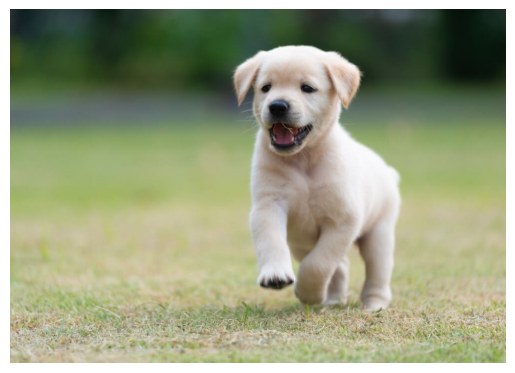

In [66]:
from torchvision.io import read_image  ## Note: feel free to use another loader
import matplotlib.pyplot as plt

image = read_image("/content/drive/MyDrive/Coursework/Fall 2023/CMSC 828I/HW2/dog.jpg")
plt.imshow(image.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()
plt.close()

### Question 2: Writing the dataset (20 points)

For this part, you need to fill in the blanks for the dataset provided below. Alternatively, feel free to write it from scratch, the scaffolding was provided to help you, not to trap you in a box.

You will also need to write a loop to construct the image, using a dataloader for your SingleImageDataset. We provide more details in comments below.

We will be grading your code and your image outputs. In Gradescope, make sure both are fully visible.

In [67]:
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class SingleImageDataset(Dataset):
    def __init__(self, img_path):
        # Load image from the drive using read_image in the form of a tensor (channel, height, width)
        self.image = read_image(img_path)
        # Resize the image to 224x224x3 (HxWxC) for the network
        self.image = transforms.functional.resize(self.image, (224, 224))
        self.num_channels, self.h, self.w = self.image.shape

    def __len__(self):
        ### TODO: 1 line of code for returning the number of pixels
        return self.h * self.w

    def __getitem__(self, idx):
        ### TODO: 2-3 lines of code for x, y, and pixel values
        x = idx % self.w
        y = idx // self.w
        intensity = self.image[:, y, x]

        return {"x": x, "y": y, "intensity": intensity}

    def get_image(self):
        return self.image


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


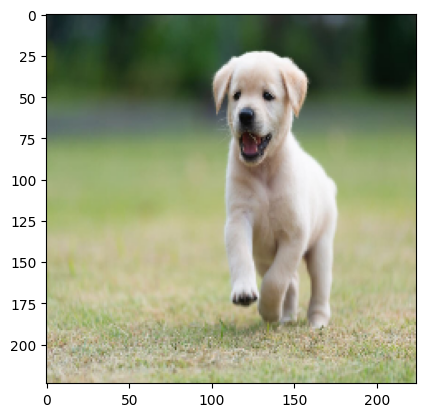

In [68]:
# Print the shape of the image
# Instantiate the dataset
dataset = SingleImageDataset("/content/drive/MyDrive/Coursework/Fall 2023/CMSC 828I/HW2/dog.jpg")
# Plot the image
plt.imshow(dataset.get_image().permute(1, 2, 0).numpy())


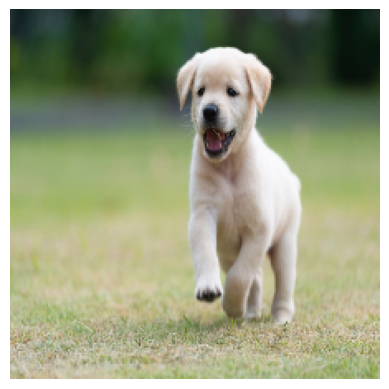

In [69]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dataset = SingleImageDataset("/content/drive/MyDrive/Coursework/Fall 2023/CMSC 828I/HW2/dog.jpg")

### TODO: 1 line of code for initializing a DataLoader
dataloader = DataLoader(dataset, shuffle=True)

### TODO: 6-10 lines of code for using your dataloader to retrieve, reassemble,
###       and display your image
some_image = torch.zeros((3, 224, 224)).type(torch.uint8)
for sample in dataloader:
    x = sample["x"]
    y = sample["y"]
    intensity = sample["intensity"]
    # Convert the float image to uint8 and assign it to the right pixel
    some_image[:, y, x] = intensity[:].reshape(3, 1)


# Convert the float image to uint8
some_image = (some_image)
# Plot the image
plt.imshow(some_image.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

## Network


### Question 3: Defining the Network (15 points)

Define a feedforward neural network.
Remember that the last layer output dimension should be equal to the number of color channels.

A very basic network might have a linear layer, followed by a ReLU, followed by another linear layer.

In [70]:
# class FFN(torch.nn.Module):
#     def __init__(self):
#         super(FFN, self).__init__()
#         ### TODO: define and initialize some layers with weights
#         self.layers = torch.nn.Sequential(
#             torch.nn.Linear(2, 1024),
#             torch.nn.ReLU(),
#             # Dropout layer
#             # torch.nn.Dropout(0.2),
#             torch.nn.Linear(1024, 512),
#             torch.nn.ReLU(),
#             # Dropout layer
#             # torch.nn.Dropout(0.2),
#             torch.nn.Linear(512, 256),
#             torch.nn.ReLU(),
#             torch.nn.Linear(256, 256),
#             torch.nn.ReLU(),
#             # Dropout layer
#             # torch.nn.Dropout(0.1),
#             torch.nn.Linear(256, 3)
#         )

#     def forward(self, coord):
#         out = self.layers(coord)
#         return out

class FFN(torch.nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        ### TODO: define and initialize some layers with weights
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            # Dropout layer
            torch.nn.Dropout(0.1),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            # Dropout layer
            torch.nn.Dropout(0.1),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 3),
        )



    def forward(self, coord):
        out = self.layers(coord)
        return out



## Training

Now that you have a dataset and model, time to put it together!

Instantiate an optimizer and a criterion.
Loop over your dataset until the network converges.
Track your loss. We will be asking you to plot it later.

In [71]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = FFN()

# Print the number of total parameters
print("Number of total parameters: ", sum(p.numel() for p in net.parameters()))
# Print the number of trainable parameters
print("Number of trainable parameters: ", sum(p.numel() for p in net.parameters() if p.requires_grad))


net.train()
net.to(device)

# since we are training the network for pixels,
# we will do a pixelwise MSE loss
criterion = torch.nn.MSELoss()


dataset = SingleImageDataset("/content/drive/MyDrive/Coursework/Fall 2023/CMSC 828I/HW2/dog.jpg")

### TODO: 1 line of code for initializing a DataLoader
dataloader = DataLoader(dataset, batch_size = 256, shuffle = True)

### TODO: 2 lines of code for optimizer, number of epochs
optimizer = torch.optim.Adam(net.parameters(), lr=0.002)
NUM_EPOCHS = 300
losses = []
batch_losses = []


### TODO: set up mechanism for storing loss values
for _ in tqdm(range(NUM_EPOCHS)):
  for batch in dataloader:
      x, y, actual = batch["x"], batch["y"], batch["intensity"].float()
      x = x / dataset.w # normalizing x between 0 and 1
      y = y / dataset.h # normalizing y between 0 and 1
      # Push x and y to the device
      x = x.to(device)
      y = y.to(device)
      actual = actual.to(device)
      ### TODO: 3 lines of code to assemble coord from x and y, pass to net,
      ###       compute loss
      coord = torch.stack((x, y), dim=1)
      pred = net(coord)
      loss = criterion(pred, actual)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      ### TODO: track loss
      batch_losses.append(loss.item())
  losses.append(sum(batch_losses) / len(batch_losses))
  batch_losses = []
  if (_+1)%25 == 0:
    print("Epoch: ", _ + 1, "Loss: ", losses[-1])

Number of total parameters:  8067
Number of trainable parameters:  8067


  8%|▊         | 25/300 [00:22<04:33,  1.00it/s]

Epoch:  25 Loss:  758.7895409720285


 17%|█▋        | 50/300 [00:43<03:19,  1.25it/s]

Epoch:  50 Loss:  553.0775317756497


 25%|██▌       | 75/300 [01:05<03:11,  1.17it/s]

Epoch:  75 Loss:  442.04982025769294


 33%|███▎      | 100/300 [01:27<03:16,  1.02it/s]

Epoch:  100 Loss:  421.2132783228037


 42%|████▏     | 125/300 [01:48<02:23,  1.22it/s]

Epoch:  125 Loss:  383.50069326283983


 50%|█████     | 150/300 [02:11<02:13,  1.12it/s]

Epoch:  150 Loss:  379.46748009506535


 58%|█████▊    | 175/300 [02:32<01:40,  1.25it/s]

Epoch:  175 Loss:  363.31578741268237


 67%|██████▋   | 200/300 [02:54<01:21,  1.23it/s]

Epoch:  200 Loss:  354.0742315954092


 75%|███████▌  | 225/300 [03:16<01:14,  1.01it/s]

Epoch:  225 Loss:  339.5458914309132


 83%|████████▎ | 250/300 [03:37<00:40,  1.24it/s]

Epoch:  250 Loss:  334.8896598815918


 92%|█████████▏| 275/300 [03:59<00:21,  1.18it/s]

Epoch:  275 Loss:  322.90137310417333


100%|██████████| 300/300 [04:21<00:00,  1.15it/s]

Epoch:  300 Loss:  322.6441516486966


In [72]:
# Print the number of total parameters
print("Number of total parameters: ", sum(p.numel() for p in net.parameters()))
# Print the number of trainable parameters
print("Number of trainable parameters: ", sum(p.numel() for p in net.parameters() if p.requires_grad))

Number of total parameters:  8067
Number of trainable parameters:  8067


### Question 4: Plot loss over time (20 points)

For this part, plot your loss from training the model.

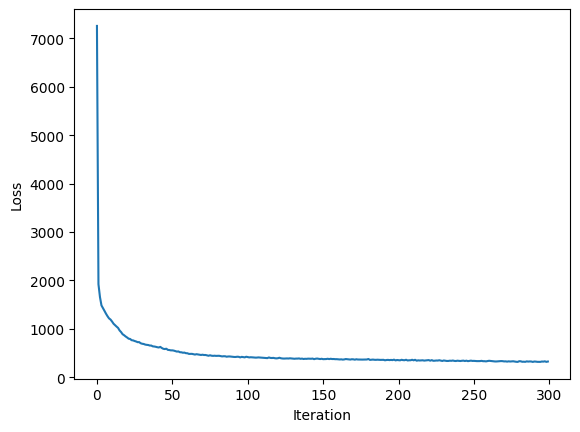

In [73]:
### TODO: make plot of reconstruction loss (y-axis) over training time (x-axis)
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

## Evaluation

### Question 5: Reconstruct whole image (20 points)

For this part, reconstruct the image using your model's outputs, at each coordinate.
You can use our scaffolding code, or write your own.
For this part, we are just grading the image plot, where you should plot the original image side-by-side with the reconstruction, as shown in this example.

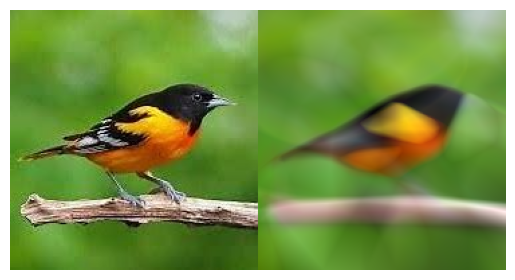

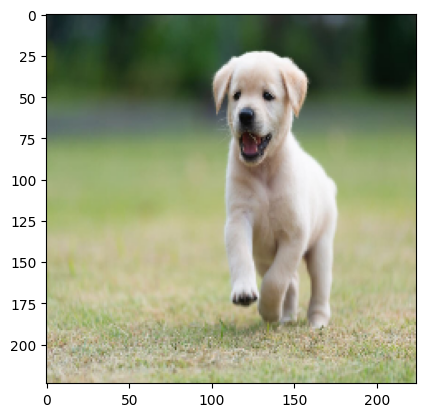

In [74]:
### TODO: ~12 lines of code to assemble gt_image, build pred_image
###       from model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate the dataset
dataset = SingleImageDataset("/content/drive/MyDrive/Coursework/Fall 2023/CMSC 828I/HW2/dog.jpg")
# Plot the image
plt.imshow(dataset.get_image().permute(1, 2, 0).numpy())
plt.show()
plt.close()

# # Instantiate the dataloader
dataloader = DataLoader(dataset, shuffle=False)
# # Instantiate the network
# net = FFN()
# # Load the weights
# net.load_state_dict(torch.load("ffn.pth"))
# # Put the network in evaluation mode
net.eval()
# # Push the network to the device
net.to(device)

# Instantiate the ground truth image
gt_image = torch.zeros((3, 224, 224)).type(torch.uint8)
# Instantiate the predicted image
pred_image = torch.zeros((3, 224, 224)).type(torch.uint8)
with torch.no_grad():

    for sample in dataloader:
        x, y, actual = sample["x"], sample["y"], sample["intensity"]
        x_norm = x / dataset.w # normalizing x between 0 and 1
        y_norm = y / dataset.h # normalizing y between 0 and 1
        # Push x and y to the device
        x_norm = x_norm.to(device)
        y_norm = y_norm.to(device)
        # Assemble coord from x and y
        coord = torch.stack((x_norm, y_norm), dim=1)
        # Pass coord to net
        pred = net(coord)
        # Assign the predicted values to the right pixel
        pred_image[:, y, x] = pred[:].reshape(3, 1).type(torch.uint8).to("cpu")
        # Assign the actual values to the right pixel
        gt_image[:, y, x] = actual[:].reshape(3, 1)


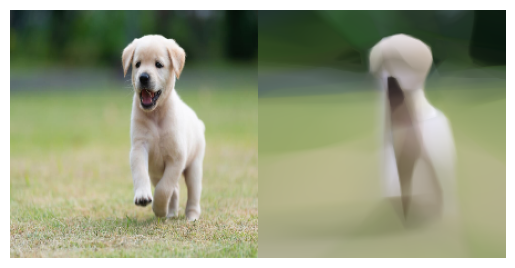

In [76]:
joint_image = torch.cat([gt_image, pred_image], dim=2)
plt.imshow(joint_image.permute(1, 2, 0))
plt.axis('off')
plt.show()
plt.close()

### Question 6: Compute PSNR (10 points)

For this part, print the PSNR for your reconstruction vs. the original image. Feel free to use any libraries, or implement it from scratch.

In [78]:
### TODO: compute and print PSNR between reconstructed (predicted) and ground truth images
###       (hint: you may want to use torch.nn.functional.mse_loss)
import torch.nn.functional as F

mse = F.mse_loss(pred_image.type(torch.float32), gt_image.type(torch.float32))
psnr = 10 * torch.log10(255*255 / mse)
print("PSNR: ", psnr.item())


PSNR:  23.002511978149414


### Question 7: Outpainting (10 points)

INR is a continuous image representation. What happens if your input coordinates don't correspond to real pixels? Try it out and show the result!

For this part, have your model predict 20 pixels in all directions that are outside the boundaries of the original image, and show the resulting image below. Also plot a box around the region corresponding to the original image, for clarity.

We show an example below.

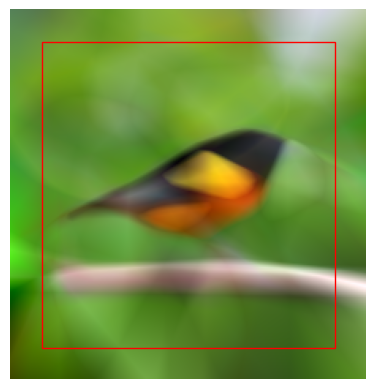

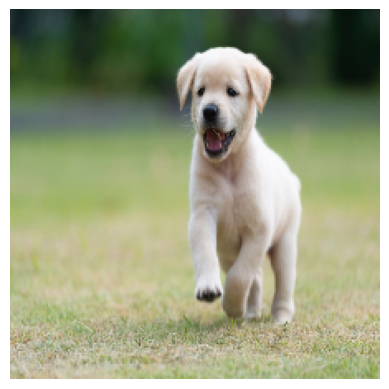

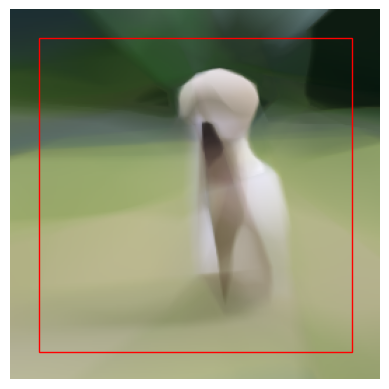

In [79]:
# Outpainting for the pixels that are present 20 pixels away from the border
import matplotlib.patches as patches
# Instantiate the dataset
dataset = SingleImageDataset("/content/drive/MyDrive/Coursework/Fall 2023/CMSC 828I/HW2/dog.jpg")
# Plot the image
plt.imshow(dataset.get_image().permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()
plt.close()

# # Instantiate the dataloader
dataloader = DataLoader(dataset, shuffle=False)
net.eval()
# # Push the network to the device
net.to(device)

# Create a new image of dimensions 264x264x3 from the original image of dimensions 224x224x3
outpainted_image = torch.zeros((3, 264, 264)).type(torch.uint8)

# Iterate through the pixels that lie outside the border of 244x244 and predict the intensity values for them
for i in range(-20, 244):
    for j in range(-20, 244):
        # if (i < 20 or i > 243) or (j < 20 or j > 243):
        x = i
        y = j
        # Normalize x and y and convert them to tensors
        x_norm = torch.tensor(x / dataset.w).to(device)
        y_norm = torch.tensor(y / dataset.h).to(device)
        # Assemble coord from x and y
        coord = torch.stack((x_norm, y_norm), dim=0)
        # Pass coord to net
        pred = net(coord)
        # Assign the predicted values to the right pixel
        outpainted_image[:, y+20, x+20] = pred.type(torch.uint8).to("cpu")


# Plot the outpainted image
fig, ax = plt.subplots()
ax.imshow(outpainted_image.permute(1, 2, 0).numpy())
rect = patches.Rectangle((20, 20), dataset.w, dataset.h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.axis('off')
plt.show()
plt.close()


## Bonus

The main idea of the bonus is to do something to make your model better than the one we walk you through in the assignment. Be creative! You can receive a maximum of 20 points for this portion.

### Question 8: Improve the Reconstruction Quality of the System (20 points, optional)

For this question, you must do two things:

1. Make a non-trivial change from what we guided you through in the assignment.
2. Prove that the change improves reconstruction quality. Compare your new output/PSNR to the old output/PSNR (plot the images, print the PSNR).

If you can't think of your own idea, revisit some of the literature from Shishira's guest lectures. For example, instead of taking raw coordinate inputs, you could try using positional encodings.

In [80]:
import numpy as np

def positional_encoding_2d(width, height, d_model):
    pos_enc = np.zeros((width, height, d_model))

    for pos_x in range(width):
        for pos_y in range(height):
            for i in range(0, d_model, 2):
                angle = pos_x / np.power(10000, 2 * i / d_model)
                pos_enc[pos_x, pos_y, i] = np.sin(angle)
                pos_enc[pos_x, pos_y, i + 1] = np.cos(angle)

    return pos_enc

# Example with a 200x200 image and a d_model of 20
width, height = 224, 224
d_model = 20

pos_encoding = positional_encoding_2d(width, height, d_model)
print(pos_encoding.shape)  # (224, 224, 20)


(224, 224, 20)


In [81]:
# class FFN(torch.nn.Module):
#     def __init__(self):
#         super(FFN, self).__init__()
#         ### TODO: define and initialize some layers with weights
#         self.layers = torch.nn.Sequential(
#             torch.nn.Linear(20, 1024),
#             torch.nn.ReLU(),
#             # Dropout layer
#             torch.nn.Dropout(0.1),
#             torch.nn.Linear(1024, 1024),
#             torch.nn.ReLU(),
#             # Dropout layer
#             torch.nn.Dropout(0.1),
#             torch.nn.Linear(1024, 512),
#             torch.nn.ReLU(),
#             torch.nn.Linear(512, 256),
#             torch.nn.ReLU(),
#             torch.nn.Dropout(0.1),
#             torch.nn.Linear(256, 256),
#             torch.nn.ReLU(),
#             torch.nn.Linear(256, 3),
#         )

#     def forward(self, coord):
#         out = self.layers(coord)
#         return out


class FFN(torch.nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        ### TODO: define and initialize some layers with weights
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(20, 64),
            torch.nn.ReLU(),
            # Dropout layer
            torch.nn.Dropout(0.1),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            # Dropout layer
            torch.nn.Dropout(0.1),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Linear(16, 3),
        )



    def forward(self, coord):
        out = self.layers(coord)
        return out


In [82]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = FFN()


# Print the number of total parameters
print("Number of total parameters: ", sum(p.numel() for p in net.parameters()))
# Print the number of trainable parameters
print("Number of trainable parameters: ", sum(p.numel() for p in net.parameters() if p.requires_grad))

net.train()
net.to(device)

# since we are training the network for pixels,
# we will do a pixelwise MSE loss
criterion = torch.nn.MSELoss()


dataset = SingleImageDataset("/content/drive/MyDrive/Coursework/Fall 2023/CMSC 828I/HW2/dog.jpg")

### TODO: 1 line of code for initializing a DataLoader
dataloader = DataLoader(dataset, batch_size = 256, shuffle = True)

### TODO: 2 lines of code for optimizer, number of epochs
optimizer = torch.optim.Adam(net.parameters(), lr=0.002)
NUM_EPOCHS = 300
losses = []
batch_losses = []


### TODO: set up mechanism for storing loss values
for _ in tqdm(range(NUM_EPOCHS)):
    for batch in dataloader:
        x, y, actual = batch["x"], batch["y"], batch["intensity"].float()
        # Encode x and y using positional encoding
        encoded_coord = torch.tensor(pos_encoding[x, y]).type(torch.float32).to(device)
        # Normalize encoded_coord
        # encoded_coord = encoded_coord / 256
        # Normalize x and y
        x = x / dataset.w
        y = y / dataset.h
        # Multiplu the first half of the encoded_coord by x and the second half by y
        encoded_coord[:, :10] = encoded_coord[:, :10] * x.unsqueeze(1).to(device)
        encoded_coord[:, 10:] = encoded_coord[:, 10:] * y.unsqueeze(1).to(device)
        # Pass encoded_coord to net
        pred = net(encoded_coord)
        loss = criterion(pred, actual.to(device))
        # Optimize the network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    losses.append(sum(batch_losses) / len(batch_losses))
    batch_losses = []
    if (_+1)%25 == 0:
      print("Epoch: ", _ + 1, "Loss: ", losses[-1])

Number of total parameters:  9219
Number of trainable parameters:  9219


  8%|▊         | 25/300 [00:23<03:57,  1.16it/s]

Epoch:  25 Loss:  494.27507548429526


 17%|█▋        | 50/300 [00:46<03:39,  1.14it/s]

Epoch:  50 Loss:  344.64431529142416


 25%|██▌       | 75/300 [01:10<03:25,  1.09it/s]

Epoch:  75 Loss:  301.15380329988443


 33%|███▎      | 100/300 [01:34<03:37,  1.09s/it]

Epoch:  100 Loss:  270.5764826560507


 42%|████▏     | 125/300 [01:57<02:31,  1.15it/s]

Epoch:  125 Loss:  261.3458264409279


 50%|█████     | 150/300 [02:21<02:11,  1.14it/s]

Epoch:  150 Loss:  238.10852284334143


 58%|█████▊    | 175/300 [02:45<01:54,  1.09it/s]

Epoch:  175 Loss:  238.72863995299048


 67%|██████▋   | 200/300 [03:09<01:39,  1.01it/s]

Epoch:  200 Loss:  230.5755555289132


 75%|███████▌  | 225/300 [03:32<01:13,  1.03it/s]

Epoch:  225 Loss:  227.38492362353267


 83%|████████▎ | 250/300 [03:56<00:43,  1.15it/s]

Epoch:  250 Loss:  229.62292970929826


 92%|█████████▏| 275/300 [04:20<00:22,  1.10it/s]

Epoch:  275 Loss:  219.33478581175513


100%|██████████| 300/300 [04:43<00:00,  1.06it/s]

Epoch:  300 Loss:  212.12831014516402


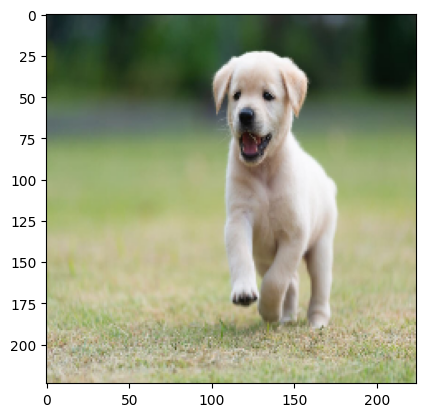

In [83]:
### TODO: bonus
import math

### TODO: ~12 lines of code to assemble gt_image, build pred_image
###       from model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Instantiate the dataset
dataset = SingleImageDataset("/content/drive/MyDrive/Coursework/Fall 2023/CMSC 828I/HW2/dog.jpg")
# Plot the image
plt.imshow(dataset.get_image().permute(1, 2, 0).numpy())
plt.show()
plt.close()

# # Instantiate the dataloader
dataloader = DataLoader(dataset, shuffle=False)
net.eval()
# # Push the network to the device
net.to(device)

# Instantiate the ground truth image
gt_image = torch.zeros((3, 224, 224)).type(torch.uint8)
# Instantiate the predicted image
pred_image = torch.zeros((3, 224, 224)).type(torch.uint8)
with torch.no_grad():
    positional_encoding = 0
    for sample in dataloader:
        x, y, actual = sample["x"], sample["y"], sample["intensity"]
        # Encode x and y using positional encoding and convert to tensor
        encoded_coord = torch.tensor(pos_encoding[x, y]).type(torch.float32).to(device)
        # Normalize encoded_coord
        # encoded_coord = encoded_coord / 256
        # Normalize x and y
        x_norm = x / dataset.w
        y_norm = y / dataset.h
        # Multiplu the first half of the encoded_coord by x and the second half by y
        encoded_coord[:10] = encoded_coord[:10] * x_norm.to(device)
        encoded_coord[10:] = encoded_coord[10:] * y_norm.to(device)
        # Pass encoded_coord to net
        pred = net(encoded_coord)
        # Assign the predicted values to the right pixel
        pred_image[:, y, x] = pred[:].reshape(3, 1).type(torch.uint8).to("cpu")
        # Assign the actual values to the right pixel
        gt_image[:, y, x] = actual[:].reshape(3, 1)




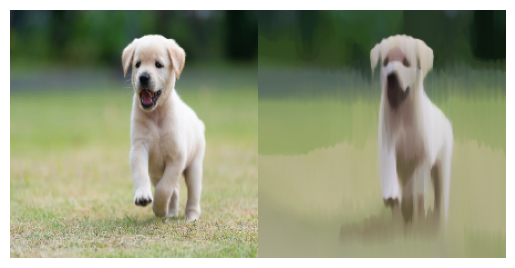

In [84]:
joint_image = torch.cat([gt_image, pred_image], dim=2)
plt.imshow(joint_image.permute(1, 2, 0))
plt.axis('off')
plt.show()
plt.close()

In [91]:
### TODO: compute and print PSNR between reconstructed (predicted) and ground truth images
###       (hint: you may want to use torch.nn.functional.mse_loss)
import torch.nn.functional as F

mse = F.mse_loss(pred_image.type(torch.float32), gt_image.type(torch.float32))
psnr = 10 * torch.log10(255*255 / mse)
print("PSNR: ", psnr.item())


PSNR:  24.389554977416992


In [86]:
# Print the number of total parameters
print("Number of total parameters: ", sum(p.numel() for p in net.parameters()))
# Print the number of trainable parameters
print("Number of trainable parameters: ", sum(p.numel() for p in net.parameters() if p.requires_grad))

Number of total parameters:  9219
Number of trainable parameters:  9219
